***
# Predict Book Sales Ranking in Amazon
### First Capstone project
***
<div class="span5 alert alert-info">

<p> The main steps of this project are: </p>
<ul>
  <li> 1.Scrape and parse Amazon Book Reviews as well as the meta data.</li>
  <li> 2.Data Wrangling</li>
    <ul>
      <li> Load in and join book review to meta data</li>
      <li> Organize review texts into a sparse data frame of word counts </li>
    </ul>
   <li>3.EDA of various predictor variables and segmentation of book sales ranking </li>
   <li>4.Construct a machine learning pipeline for nested cross-validation </li>
</ul>
</div>

***



In [1]:
import os
import pandas as pd
import numpy as np
import scipy
import re
from __future__ import print_function

from pprint import pprint
from time import time
import logging

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2

from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

from sklearn.pipeline import Pipeline

import seaborn as sns

import matplotlib.pyplot as plt
# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


/Users/yizhao/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Automatically created module for IPython interactive environment


In [2]:
# load in the raw data as csv
joined_data = pd.read_csv('/Users/yizhao/Documents/First_capstone/joined_data.csv')

# load in earlier data frame of word counts
#spread_titles = pd.read_csv('/Users/yizhao/Documents/First_capstone/spread_titles.csv')
#spread_reviews = pd.read_csv('/Users/yizhao/Documents/First_capstone/spread_reviews.csv')

In [3]:
# parse out the bag of words for both Titles and the Reviews

X_titles = [''.join(r) for r in joined_data.review_titles]

X_reviews = [''.join(r) for r in joined_data.reviews]

y = joined_data.sales_rank.values # the prediction target
b = joined_data.list_name.astype(str).values # book list names

In [4]:
y_log = np.log(y)
y_log[:5]

array([ 2.89037176,  0.69314718,  4.18965474,  4.9698133 ,  4.35670883])

### Apply Kfold cross validation as model evaluation

In [67]:
def cv_score(clf, X, y, scorefunc,nfold):
    train_error = 0.
    test_error = 0.
    for train, test in KFold(nfold, shuffle=True).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        train_error += scorefunc(clf.predict(X[train]), y[train]) 
        test_error += scorefunc(clf.predict(X[test]), y[test])
        # evaluate score function on held-out data
    return [train_error/ nfold,test_error/ nfold]  # average

### Use Review titles to predict sales rank

In [60]:
# define a count vectorizer object
vec = CountVectorizer(min_df = 1, stop_words='english')

# fit and transform all the text data
X = vec.fit_transform(X_titles)

In [68]:
# fit with Random forest regresson

RF = RandomForestRegressor(n_estimators= 100)

# apply a five fold cross validation
CV_result = cv_score(RF, X, y,mean_squared_error, nfold=5)

# assess accuracy
print('Titles Random forest fit')
print('Training set Cross Validated Mean RMSE: ',
      CV_result[0])

print('Testing set Cross Validated Mean RMSE: ',
      CV_result[1])


Titles Random forest fit
Training set Cross Validated Mean RMSE:  7287.62068934
Testing set Cross Validated Mean RMSE:  53809.3100739


In [64]:
print('Mean of Sales Rank: ', np.mean(y))

Mean of Sales Rank:  130.412698413


Given the average of sales rank value, our RMSE from the testing set is as high as 500 times of this value, while the training set has a much lower RMSE value. So the model is overfitting.

### Use review texts to predict sales rank

In [69]:
# fit and transform all the review data
vec = CountVectorizer(min_df = 1,  stop_words='english') # increase into bigram to see if results are better
#ngram_range=(1,2),

X = vec.fit_transform(X_reviews)

RF = RandomForestRegressor(n_estimators= 100)

# apply a five fold cross validation
CV_result = cv_score(RF, X, y,mean_squared_error, nfold=5)

# assess accuracy
print('Review texts Random forest fit')
print('Training set Cross Validated Mean RMSE: ',
      CV_result[0])

print('Testing set Cross Validated Mean RMSE: ',
      CV_result[1])



Review texts Random forest fit
Training set Cross Validated Mean RMSE:  7252.1974392
Testing set Cross Validated Mean RMSE:  49642.4404985


The test set fit is still disappointing, but it's slightly better than using the review titles. There is likely more indstinguishing information available in the review texts.

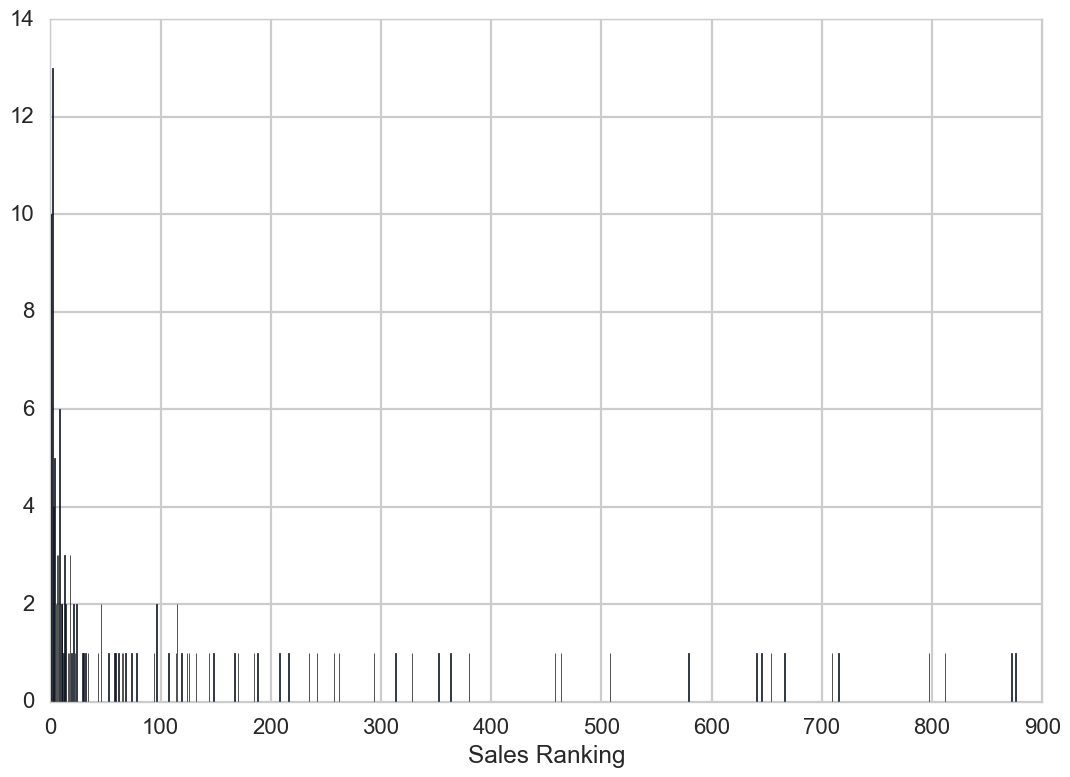

In [71]:
plt.hist(y,bins=2000)
plt.xlabel('Sales Ranking')
plt.show()

As seen above, the sales ranks are highly skewed. Taking the log transformation may helps improve the model performances. 

In [72]:
# try using log transformation to fit the random forest regressor
CV_result = cv_score(RF, X, y_log,mean_squared_error, nfold=5)

# assess accuracy
print('Review texts random forest fit with log of sales rank')
print('Training set Cross Validated Mean RMSE: ',
      CV_result[0])

print('Testing set Cross Validated Mean RMSE: ',
      CV_result[1])

Review texts random forest fit with log of sales rank
Training set Cross Validated Mean RMSE:  0.628350520211
Testing set Cross Validated Mean RMSE:  4.59090872064


In [73]:
print('Mean of log(sales rank): ', np.mean(y_log))

Mean of log(sales rank):  3.24303974213


The model is still over fitting in that the training set has a RMSE that is about 14% of the traning set. However, the training set RMSE is less than twice as large as the mean of log(sales rank), compared to being 400 to 500 times as large. So log transformation did improve the model. Another way to improve the model is to use bigram as opposed to unigram in the countVectorizer transformation. Some negations will thus be accounte for, such as 'not good'.

In [167]:
# fit and transform all the review data using bigram
vec_2 = CountVectorizer(min_df = 1,  stop_words='english',ngram_range=(1,2)) # increase into bigram to see if results are better

X_2 = vec_2.fit_transform(X_reviews)



In [168]:
RF = RandomForestRegressor(n_estimators= 100)

# apply a five fold cross validation
CV_result = cv_score(RF, X_2, y_log,mean_squared_error, nfold=5)

# assess accuracy
print('Review texts Random forest fit with bigram text transformation')
print('Training set Cross Validated Mean RMSE: ',
      CV_result[0])

print('Testing set Cross Validated Mean RMSE: ',
      CV_result[1])

Review texts Random forest fit with bigram text transformation
Training set Cross Validated Mean RMSE:  0.614651253969
Testing set Cross Validated Mean RMSE:  4.30538730279


The testing error is slightly improved, but it does not seem to be a critical amount of difference to spend this extra computation on bigram transformation as opposed to unigram. So the rest of the analysis will continue to use unigram. 

#### Try adaboost, as a boosted ensemble method

In [84]:
from sklearn.ensemble import AdaBoostRegressor
adaboost = AdaBoostRegressor(n_estimators = 60) 
# default is 50 for The maximum number of estimators at which 
# boosting is terminated.

In [83]:
# try using log transformation to fit the random forest regressor
CV_result = cv_score(adaboost, X, y_log,mean_squared_error, nfold=5)

# assess accuracy
print('Adaboost fit with log of sales rank')
print('Training set Cross Validated Mean RMSE: ',
      CV_result[0])

print('Testing set Cross Validated Mean RMSE: ',
      CV_result[1])

Adaboost fit with log of sales rank
Training set Cross Validated Mean RMSE:  0.397076455489
Testing set Cross Validated Mean RMSE:  4.83671508105


The resulting test error was not lowered compared to using random forest.
Another classification tree based ensemble method is the XGBoost regressor. The advantage of this method is that it allows for tree pruning of each regression tree.

#### Try XGBoost with tree pruning option

In [89]:
from xgboost import XGBRegressor

In [152]:
# first find the optimal 'max_depth' parameter into the XGBoost regressor
grid_search = GridSearchCV(XGBRegressor(), {'max_depth':[1,2,3,4,5]})
grid_search.fit(X.toarray(), y_log)
print(grid_search.best_estimator_.get_params())

{'base_score': 0.5, 'reg_alpha': 0, 'learning_rate': 0.1, 'objective': 'reg:linear', 'colsample_bytree': 1, 'nthread': -1, 'max_delta_step': 0, 'reg_lambda': 1, 'min_child_weight': 1, 'missing': None, 'max_depth': 1, 'colsample_bylevel': 1, 'gamma': 0, 'silent': True, 'seed': 0, 'scale_pos_weight': 1, 'subsample': 1, 'n_estimators': 100}


In [95]:
#define xgboost
xgb = XGBRegressor(max_depth = 1) # the default max_depth of tree is 3

# fit the XGBoost regressor
CV_result = cv_score(xgb, X.toarray(), y_log,mean_squared_error, nfold=5)

# assess accuracy
print('XGBregressor fit with tree pruning')
print('Training set Cross Validated Mean RMSE: ',
      CV_result[0])

print('Testing set Cross Validated Mean RMSE: ',
      CV_result[1])

XGBregressor fit with tree pruning
Training set Cross Validated Mean RMSE:  1.05583242693
Testing set Cross Validated Mean RMSE:  3.97399756216


The resulting test error is the lowest we had so far. Also, using a higher max_depth decreases training error, but increases the test error. So max_depth = 1 is the best performing parameter.
However, we are still overfitting the model. Functions with built in feature selection processes may be better at lowering the test error, such as LASSO regression.
#### Attempt LASSO regression with built in feature selection

In [74]:
# Try LASSO

lasso = linear_model.Lasso(alpha=2, max_iter=1e4)

CV_result = cv_score(lasso, X, y_log,mean_squared_error, nfold=5)

# assess accuracy
print('LASSO fit with log of sales rank')
print('Training set Cross Validated Mean RMSE: ',
      CV_result[0])

print('Testing set Cross Validated Mean RMSE: ',
      CV_result[1])

LASSO fit with log of sales rank
Training set Cross Validated Mean RMSE:  1.61825758486
Testing set Cross Validated Mean RMSE:  6.98550427869


Both the training and testing results are worse than Random Forest or Adaboost Regressor. Another way to potentially improve our model fit is to transform the word count into an importance index of the words. 
#### Attempt Tf-idf transformation

In [75]:
# try using Tf-idf
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(X_reviews)

# Fit Random forest regressor
CV_result = cv_score(RF, Xtfidf, y_log,mean_squared_error, nfold=5)

# assess model fit
print('Review texts Xtfidf transform random forest fit')
print('Training set Cross Validated Mean RMSE: ',
      CV_result[0])

print('Testing set Cross Validated Mean RMSE: ',
      CV_result[1])


Review texts Xtfidf transform random forest fit
Training set Cross Validated Mean RMSE:  0.614902158718
Testing set Cross Validated Mean RMSE:  4.88220336674


Again, the training set's RMSE is less than 15% of the testing set's. 
And using the Tfidf Transformer did not help with improving the model fit on the test set. 
This incidates that our model is still significantly overfitting given our 48K plus predictor features. We need to reduce the number of features here.

### Feature dimension reduction using PCA

(126, 48209)
(126, 126)
(126, 48209)


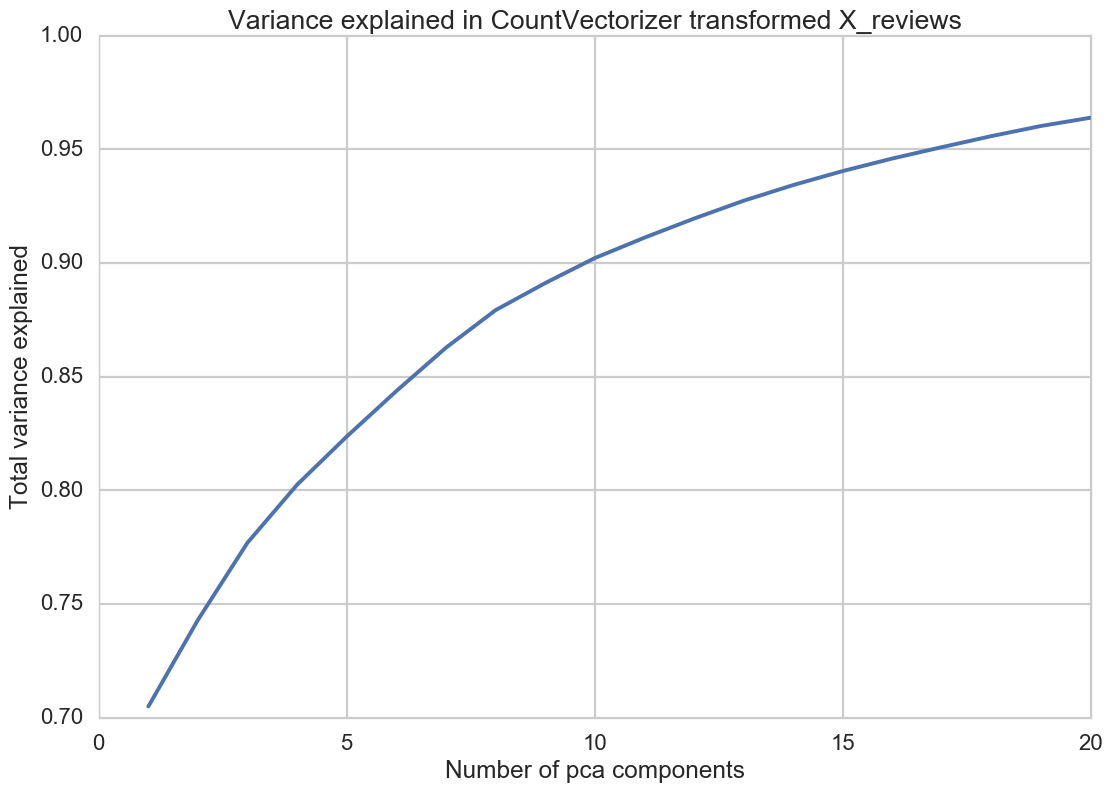

In [77]:
# first try the default number of components in PCA
# note: X = vec.fit_transform(X_reviews)
pca_default = PCA()
pca_fit = pca_default.fit(X.toarray())

pca_data = pca_default.transform(X.toarray())
print(pca_fit.components_.shape)
print(pca_data.shape)
print(X.toarray().shape)

# plot the amount of variance explained by having each additinal component
plt.plot(range(1, 21), 
         pca_default.explained_variance_ratio_.cumsum()[:20])
plt.xlabel('Number of pca components')
plt.ylabel('Total variance explained')
plt.title('Variance explained in CountVectorizer transformed X_reviews')
plt.show()

It looks like 10 pca components is a good cutoff point, explaining 90% of variance in the review text data.

In [88]:
# use the PCA fit to train a random forest model
pca = PCA(n_components= 10)

X = vec.fit_transform(X_reviews)

train_error = 0.
test_error = 0.
nfold = 5
for train, test in KFold(nfold, shuffle=True).split(X): # split data into train/test groups, 5 times
    #fit PCA on the training set
    pca_Xtrain = pca.fit_transform(X[train].toarray())

    # PCA transform the test set using the fit from the training set
    pca_Xtest = pca.transform(X[test].toarray())

    RF.fit(pca_Xtrain, y_log[train]) # fit the classifier, passed is as clf.
    train_error += mean_squared_error(RF.predict(pca_Xtrain), y_log[train]) 
    test_error += mean_squared_error(RF.predict(pca_Xtest), y_log[test])
 
# assess model fits
print('Review texts PCA transformed random forest fit')
print('Training set Cross Validated Mean RMSE: ',
      train_error)

print('Testing set Cross Validated Mean RMSE: ',
      test_error)

Review texts PCA transformed random forest fit
Training set Cross Validated Mean RMSE:  3.08498784993
Testing set Cross Validated Mean RMSE:  21.9847864442


This test set fit is remarkably worse than the previous result. 
Thus, PCA did not appear to be an effective feature selection method. 

#### EDA on relationship between review texts and the book lists
What if using the review texts to predict the categories of books, as opposed to the sales rank? What that yield a much more accurate result?

In [13]:
vec = CountVectorizer(min_df = 1,  stop_words='english') # increase into bigram to see if results are better
#ngram_range=(1,2),

X = vec.fit_transform(X_reviews)

# split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, b)


# Fit Random forest classifier

RF = RandomForestClassifier(n_estimators= 100)
RF.fit(Xtrain, ytrain)

# assess accuracy
print('Review texts random forest classifier fit')
print('Train accuracy: ',accuracy_score(RF.predict(Xtrain), ytrain))
print('Test accuracy: ',accuracy_score( RF.predict(Xtest), ytest))




Review texts random forest classifier fit
Train accuracy:  1.0
Test accuracy:  0.5625


The test accuracy isn't great, but better than prediction results of the sales rank. What if the 'best_seller' list is removed (that list may have books with various different genres).

In [14]:
joined_data.list_name.unique()

array(['lifetime', 'thriller', 'best_seller', 'biography', 'children'], dtype=object)

In [22]:
sub_data = joined_data[joined_data.list_name.values != 'best_seller']
sub_reviews = [''.join(r) for r in sub_data.reviews]

sub_ylog = np.log(sub_data.sales_rank.values)
sub_b = sub_data.list_name.astype(str).values 

In [20]:
vec = CountVectorizer(min_df = 1,  stop_words='english') # increase into bigram to see if results are better
#ngram_range=(1,2),

X = vec.fit_transform(sub_reviews)

# split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, sub_b)


# Fit Random forest classifier

RF = RandomForestClassifier(n_estimators= 100)
RF.fit(Xtrain, ytrain)

# assess accuracy
print('Review texts random forest classifier fit')
print('Train accuracy: ',accuracy_score(RF.predict(Xtrain), ytrain))
print('Test accuracy: ',accuracy_score( RF.predict(Xtest), ytest))




Review texts random forest classifier fit
Train accuracy:  1.0
Test accuracy:  0.72


Indeed, the classification accuracy becomes much better with the 'best_seller' list removed.
What about the sales ranking then?

In [25]:
# split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, sub_ylog)

pca = PCA(n_components= 10)
# fit PCA on the training set
pca_Xtrain = pca.fit_transform(Xtrain.toarray())

# PCA transform the test set using the fit from the training set
pca_Xtest = pca.transform(Xtest.toarray())


# Fit Random forest regressor
RF = RandomForestRegressor(n_estimators= 100)
RF.fit(pca_Xtrain, ytrain)

# assess accuracy
print('Review texts non best-seller list random forest fit')
print('Train explained variance: ',explained_variance_score(ytrain, RF.predict(pca_Xtrain)))
print('Test explained variance: ',explained_variance_score( ytest, RF.predict(pca_Xtest)))



Review texts non best-seller list random forest fit
Train explained variance:  0.862096389027
Test explained variance:  -0.499366464512


Removing 'best_selling' books improved the fit for book list names, but not for the sales rank.
So the book list information is not as significant to the sales ranking.

#### Try Kmeans and hierarchical clustering and see if there is any seperability in the sales ranking distributions of various clusters.

In [91]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [10]:
vec = CountVectorizer(min_df = 1,  stop_words='english') 

X = vec.fit_transform(X_reviews)

In [92]:
# compute the score for Kmeans fits of a range of n_clusters

K = range(2,21,1) # try out K for values 2 to 20

# a list of fitted Kmeans results
KM = [KMeans(n_clusters=k).fit(X) for k in K]

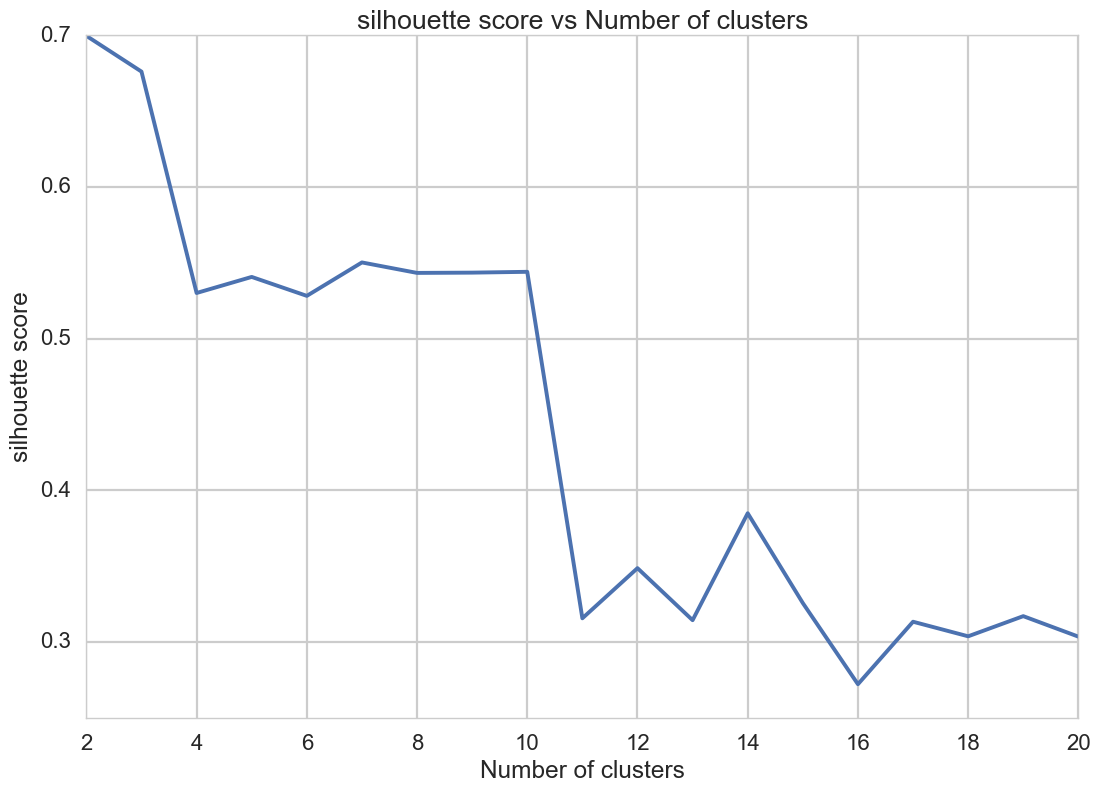

In [13]:
# a list of centroids from the previous KM fits
sh_score = [silhouette_score(X = X,
                             labels = k.predict(X)) for k in KM]

plt.plot(K,  sh_score)
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')
plt.title('silhouette score vs Number of clusters')
plt.show()

Ideally, the silouette score should increase with an increasing number of clusters, but it doesn't seem to be the case here. 2 clusters has the best score.

In [16]:
# fit the agglomerative clustering
ac = AgglomerativeClustering()  # default is 2 clusters

ac_labels = ac.fit_predict(X.toarray())

print('Silhouette score: \n')
print(silhouette_score(X.toarray(), ac_labels, metric='euclidean'))

# the score looks the same as the Kmean result

Silhouette score: 

0.699768032644


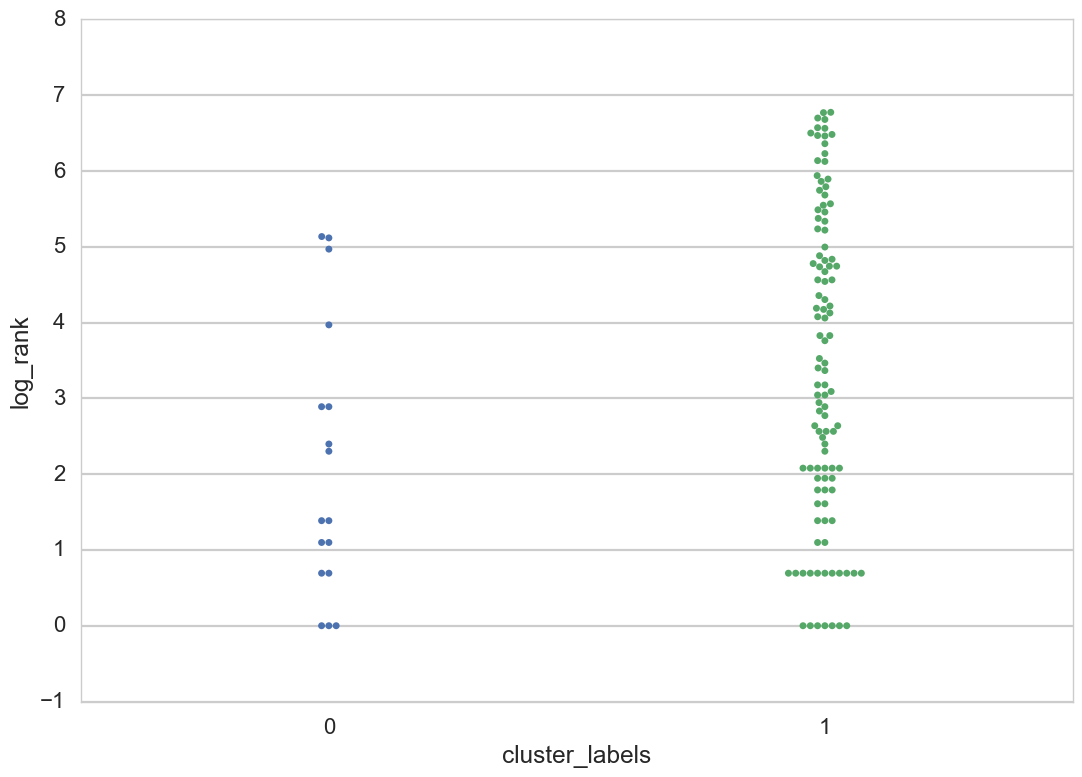

In [22]:
toplot = pd.DataFrame({"cluster_labels": ac_labels,
                      'log_rank': y_log})
sns.swarmplot(x="cluster_labels", y="log_rank", data=toplot)
plt.show()

At least one cluster has a smaller range in sales rank than the other, but there doesn't seem to be any significant differences between the two clusters.

#### Attempt other feature selection to reduce the dimensionality of the data

In [40]:
from sklearn.feature_selection import f_regression

In [ ]:
vec = CountVectorizer(min_df = 1,  stop_words='english') 

X = vec.fit_transform(X_reviews)

In [51]:
f_reg = f_regression(X.toarray(), y_log)
f_r = f_reg[0] / np.max(f_reg[0]) # fraction of the most significant

print('F-stat:\n', f_reg[0])
print('p-values:\n',f_reg[1]) 

F-stat:
 [ 2.15040394  1.85464042  0.12520903 ...,  0.82072374  0.82072374
  0.02942134]
p-values:
 [ 0.14506385  0.17571368  0.72405308 ...,  0.36672562  0.36672562
  0.86408941]


In [53]:
voc_F = pd.DataFrame({"voc": list(vec.vocabulary_.keys()), "p_val": f_reg[1]})
voc_F.head()

,p_val,voc
0,0.145064,search
1,0.175714,similiar
2,0.724053,underestand
3,0.113665,dv
4,0.776213,blatantly


In [56]:
print('Number of words with a p-value < 0.05 from F-reg ',
     voc_F[voc_F.p_val<0.05].size)
sorted_F = voc_F.sort_values('p_val')
sorted_F

Number of words with a p-value < 0.05 from F-reg  3656


,p_val,voc
8871,0.000328,juvenalian
17992,0.000408,flip
38139,0.000416,disguise
3389,0.000438,elvis
10599,0.000543,credibly
39809,0.001067,appericate
19388,0.001099,ramadi
45940,0.001246,spontaneous
8960,0.001403,mack
3955,0.001424,et


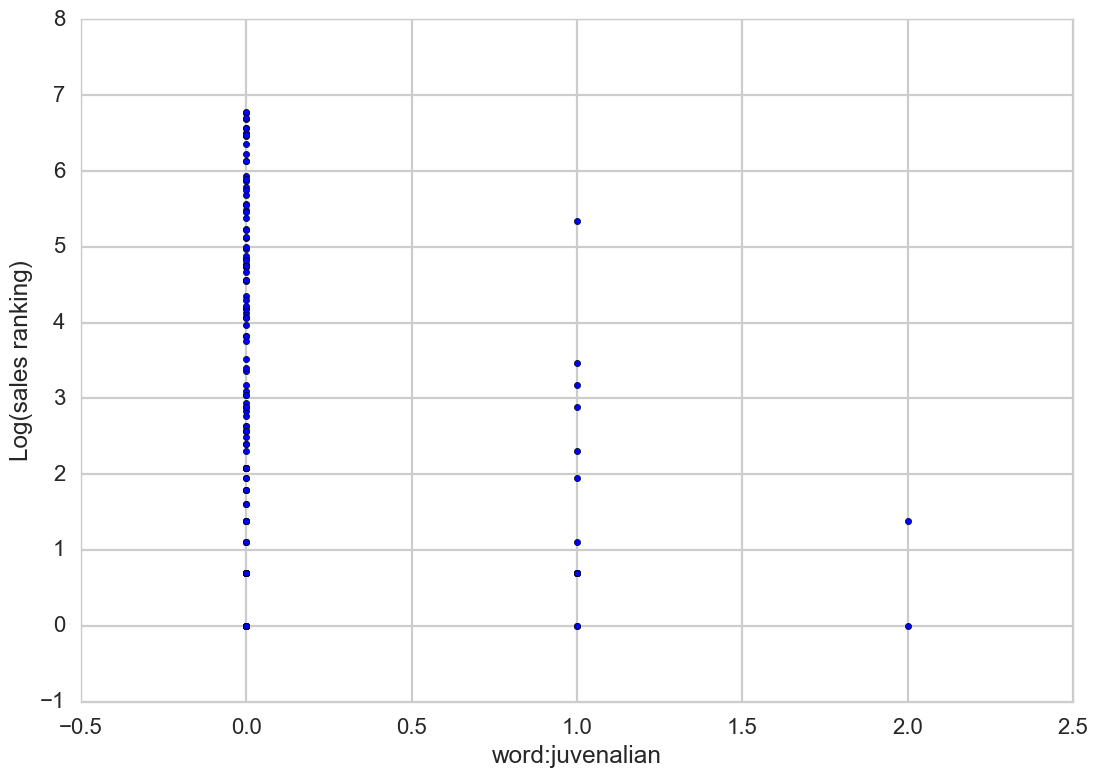

In [58]:
# plot the most signfiicant word against the log sales rank
plt.scatter(X.toarray()[:,sorted_F.index[0]], y_log)
plt.xlabel("word:"+sorted_F.iloc[0,1])
plt.ylabel('Log(sales ranking)')
plt.show()

This doesn't give us much information at all, especially because of the untested Heteroscedasticity in these indiviual linear models. As the amount of variation dwindles significantly with so few values of the predictor variable, we cannot rely on the seemingly linear relationship. However, since our actual fitting models are all based on classification trees, the failed normality assumption to linear regression will not influence our results.

In [144]:
n_features = 50
X_f = X.toarray()[:,sorted_F.index[:n_features]] # choose the top 150 important features

# Fit Random forest regressor
CV_result = cv_score(RF, X_f, y_log,mean_squared_error, nfold=10)

# assess model fit
print('F-regression selected feature random forest fit')
print('Training set Cross Validated Mean RMSE: ',
      CV_result[0])

print('Testing set Cross Validated Mean RMSE: ',
      CV_result[1])

F-regression selected feature random forest fit
Training set Cross Validated Mean RMSE:  0.643110385537
Testing set Cross Validated Mean RMSE:  3.68774275201


In [146]:
n_features = 50
X_f = X.toarray()[:,sorted_F.index[:n_features]] # choose the top 150 important features

# Fit XGBoost regressor
CV_result = cv_score(xgb, X_f, y_log,mean_squared_error, nfold=5)

# assess model fit
print('F-regression selected feature XGBoost fit')
print('Training set Cross Validated Mean RMSE: ',
      CV_result[0])

print('Testing set Cross Validated Mean RMSE: ',
      CV_result[1])

F-regression selected feature XGBoost fit
Training set Cross Validated Mean RMSE:  2.10093183395
Testing set Cross Validated Mean RMSE:  3.1866757954


In [6]:
from sklearn.feature_selection import mutual_info_regression

In [5]:
vec = CountVectorizer(min_df = 1,  stop_words='english') 

X = vec.fit_transform(X_reviews)

In [7]:
mutual_info = mutual_info_regression(X, y_log)

In [30]:
mi = mutual_info/np.max(mutual_info)

voc_mi = pd.DataFrame({"voc": list(vec.vocabulary_.keys()), "mi": mi})
voc_mi.head()

,mi,voc
0,0.000000e+00,search
1,1.158318e-01,similiar
2,3.963550e-15,underestand
3,3.963550e-15,dv
4,3.963550e-15,blatantly


In [131]:
print('Number of words that are more than 50% important of the most important word: ',
     voc_mi[voc_mi.mi>0.5].size)
sorted_mi = voc_mi.sort_values('mi', ascending=False)
sorted_mi

Number of words that are more than 50% important of the most important word:  116


,mi,voc
9766,1.000000,00o
34830,0.955791,craftmanship
45586,0.935465,gt
3284,0.935115,rendered
7854,0.874807,exce
31131,0.867627,subcommittee
31616,0.854481,withthem
42638,0.837959,worshiping
46195,0.743017,plebs
28807,0.731218,anticipating


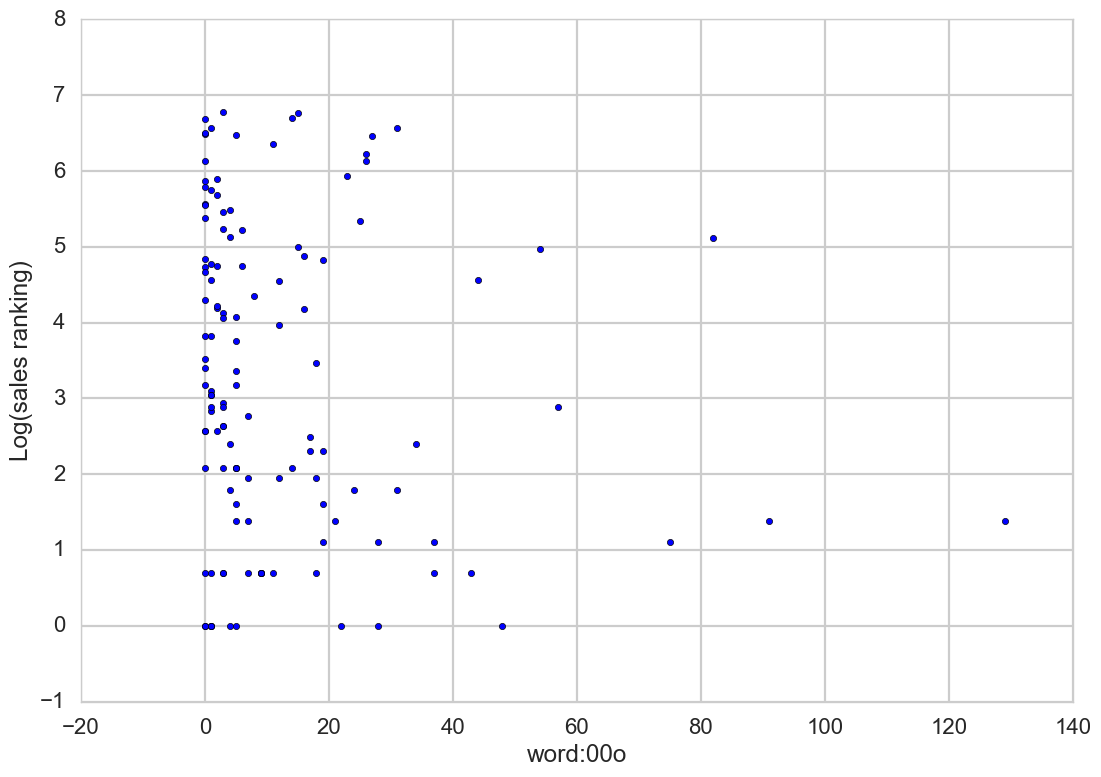

In [28]:
plt.scatter(X.toarray()[:,sorted_mi.index[0]], y_log)
plt.xlabel("word:"+sorted_mi.iloc[0,1])
plt.ylabel('Log(sales ranking)')
plt.show()

In [132]:
# for the purpose of being consistent with the previous analysis,
# still use Random Forest regressor
# split the data into training and testing sets
n_features = 40
X_mi = X.toarray()[:,sorted_mi.index[:n_features]] # choose the top 150 important features

# Fit Random forest regressor
CV_result = cv_score(RF, X_mi, y_log,mean_squared_error, nfold=10)

# assess model fit
print('Mutual Information selected feature random forest fit')
print('Training set Cross Validated Mean RMSE: ',
      CV_result[0])

print('Testing set Cross Validated Mean RMSE: ',
      CV_result[1])

Mutual Information selected feature random forest fit
Training set Cross Validated Mean RMSE:  0.589920582426
Testing set Cross Validated Mean RMSE:  4.41393534437


In [135]:
n_features = 40
X_mi = X.toarray()[:,sorted_mi.index[:n_features]]

# Fit XGBoost regressor
CV_result = cv_score(xgb, X_mi, y_log,mean_squared_error, nfold=5)

# assess model fit
print('Mutual Information selected feature XGBoost fit')
print('Training set Cross Validated Mean RMSE: ',
      CV_result[0])

print('Testing set Cross Validated Mean RMSE: ',
      CV_result[1])

Mutual Information selected feature XGBoost fit
Training set Cross Validated Mean RMSE:  2.27819288313
Testing set Cross Validated Mean RMSE:  4.32271811675


### Optimize the parameters to count vectorizer

In [147]:
# try a pipeline with random forest instead

pipeline = Pipeline([
    #('vect', CountVectorizer(stop_words= 'english')),
    
    #('pca', PCA()),
    #('svd', TruncatedSVD()),
    ('RF', RandomForestRegressor(n_estimators = 100)),
])
parameters = {
#    'vect__min_df': (1,2,3),
#    'vect__max_features': (None, 3000,5000),
#    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'pca__n_components':(10,20,40),
    #'svd__n_components':(10,20,40),
    #'RF__n_estimators': (100,200,500),
    'RF__min_impurity_split': (1e-7,1e-5,1e-3,0.01)
}

In [148]:
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X, y_log)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['RF']
parameters:
{'RF__min_impurity_split': (1e-07, 1e-05, 0.001, 0.01)}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.8min finished


done in 139.473s

Best score: -0.040
Best parameters set:
	RF__min_impurity_split: 1e-07


### Last bet: put the currently best model from F-regression feature selection and XGBoost regressor together with the rest of the predictor variables


In [154]:
# additional predictor variables
vars_add = np.column_stack((#b,
                     np.log(joined_data.review_count.values),
                     joined_data.date_delta.values,# relative measure of publish date
                    #joined_data.publisher.values
                    ))

n_features = 50
X_f = X.toarray()[:,sorted_F.index[:n_features]] # choose the top 150 important features

X_all = np.column_stack((X_f, 
                     vars_add)) 

In [158]:
# generate a boolean index to include only non null values
null_i = np.isnan(X_all).any(axis=1)

# Fit XGBoost regressor
CV_result = cv_score(xgb, X_all[~null_i],
                     y_log[~null_i],
                     mean_squared_error, nfold=5)

# assess model fit
print('Mutual Information selected feature XGBoost fit')
print('Training set Cross Validated Mean RMSE: ',
      CV_result[0])

print('Testing set Cross Validated Mean RMSE: ',
      CV_result[1])

Mutual Information selected feature XGBoost fit
Training set Cross Validated Mean RMSE:  1.91036118649
Testing set Cross Validated Mean RMSE:  3.30506024669


In [162]:
# In order to improve our confidence in the final RMSE estimate, 
# estimate a distribution of this test error with 1000 runs
test_rmse = list()
for i in range(1000):
    test_rmse.append(cv_score(xgb, X_all[~np.isnan(X_all).any(axis=1)],
                     y_log[~np.isnan(X_all).any(axis=1)],
                     mean_squared_error, nfold=5)[1] )

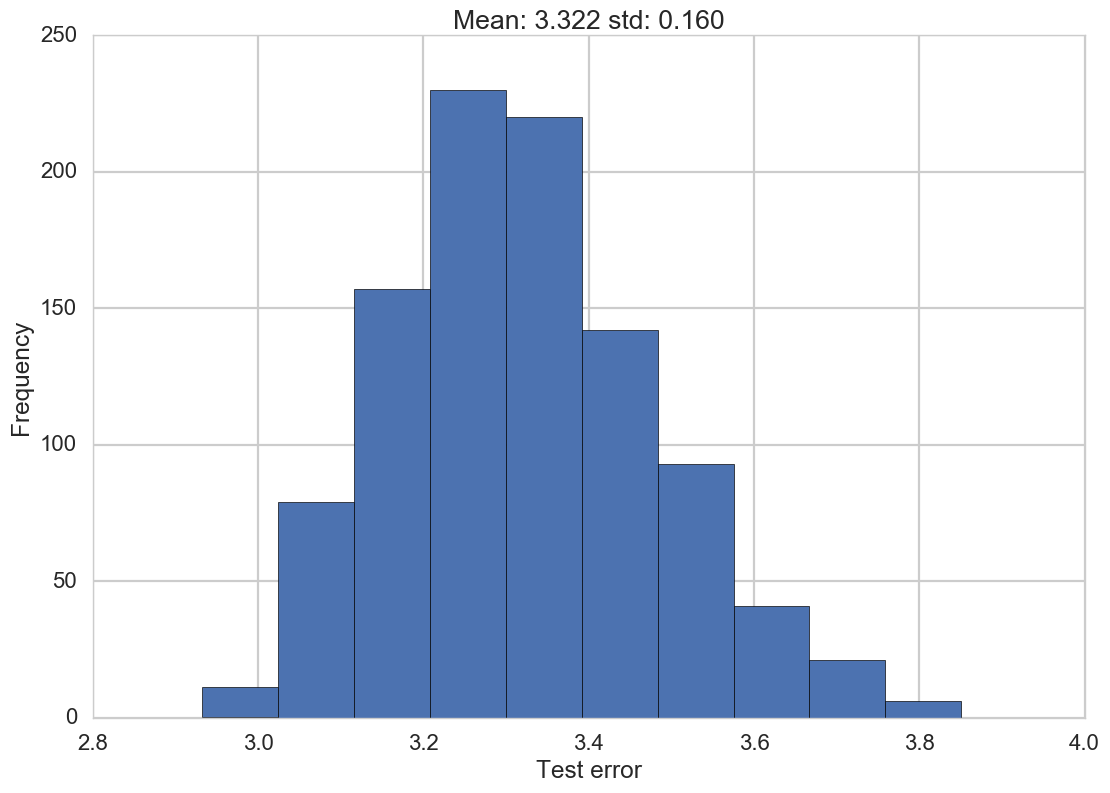

In [166]:
plt.hist(test_rmse)
plt.xlabel('Test error')
plt.ylabel('Frequency')
plt.title('Mean: %0.3f std: %0.3f' % (np.mean(test_rmse), np.std(test_rmse)))
plt.show()

The results are similar to not using the added predictor variables.

### Model evaluation
Evaluate our model fit for the two best performing models:
1. XGBoost on top 50 features selected from the F-regression method
2. XGBoost on top 50 features selected from the F-regression method plus the log_reivew_count and date_delta variable

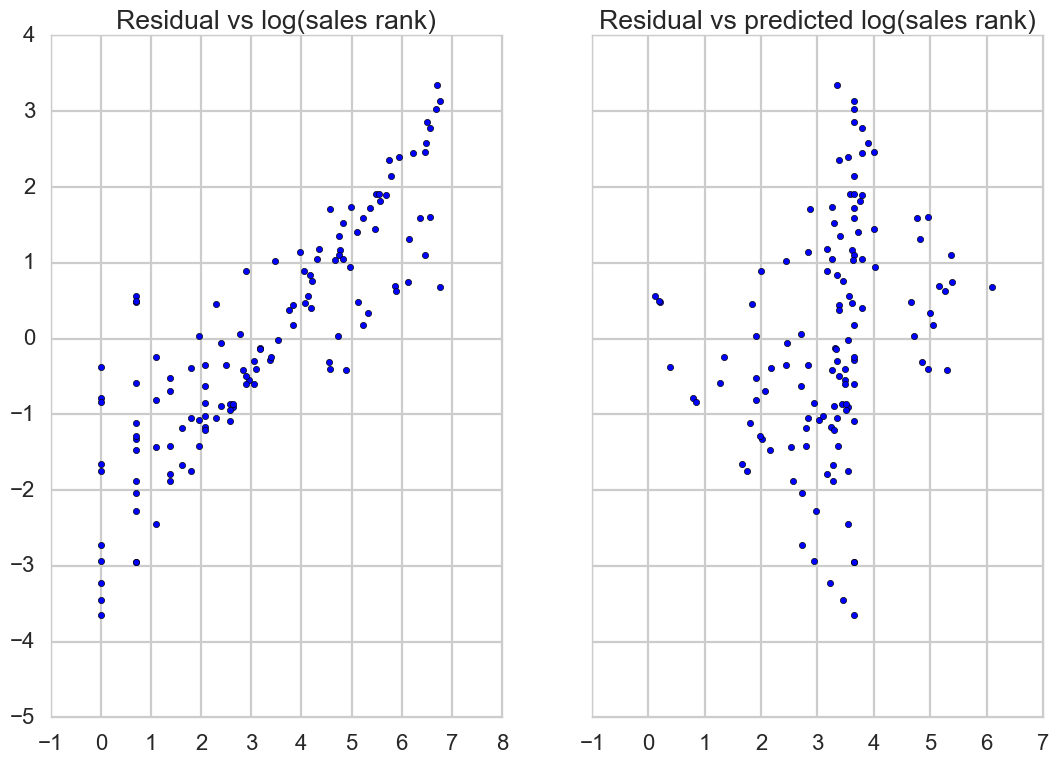

In [173]:
# fit model using XGBoost
fit_1 = xgb.fit(X_f, y_log)
pred_1 = xgb.predict(X_f)
# get model residual for plotting against the predicted values
res_1 = y_log - pred_1

# plot the residual against the predicted values
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(y_log, res_1)
ax1.set_title('Residual vs log(sales rank)')
ax2.set_title('Residual vs predicted log(sales rank)')
ax2.scatter(pred_1, res_1)
plt.show()

In [175]:
r2_score(y_log, pred_1) 
# about 47% of the variation in log sales rank is explained by our model

0.46982981942867807

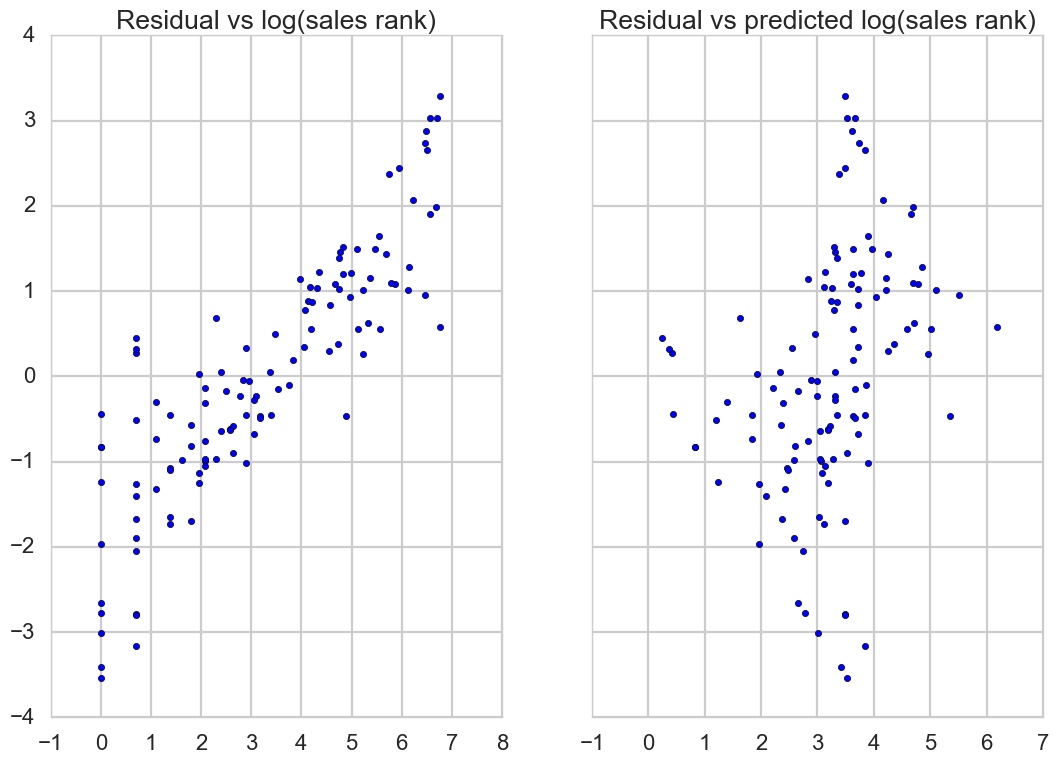

In [174]:
# fit model using all data
fit_2 = xgb.fit(X_all[~null_i],
                     y_log[~null_i])
pred_2 = xgb.predict(X_all[~null_i])
# get model residual
res_2 = y_log[~null_i] - pred_2

# plot the residual against the predicted values
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(y_log[~null_i], res_2)
ax1.set_title('Residual vs log(sales rank)')
ax2.set_title('Residual vs predicted log(sales rank)')
ax2.scatter(pred_2, res_2)
plt.show()

In both models, there is a significant positive linear relationship between y and y-yhat. In other words, the log(sales ranking) is underestimate at high values and overestimated at low levels. The residual and predicted values do appear to be uncorrelated with each other.

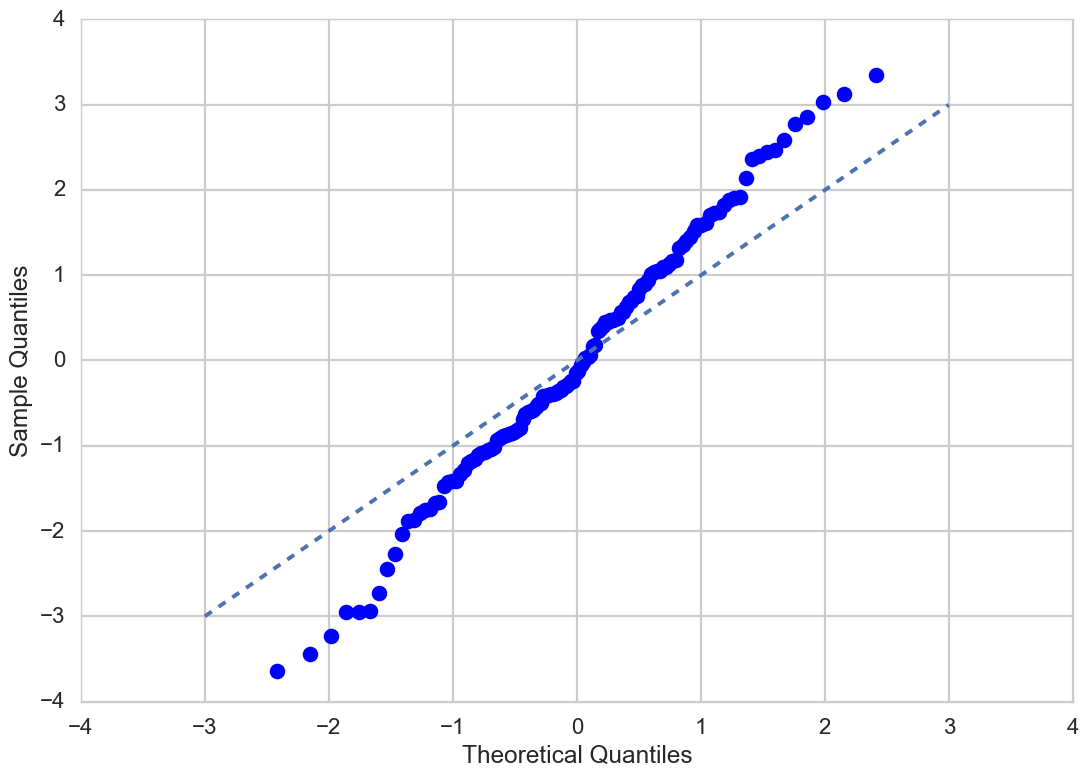

In [177]:
#quantile plot of the residuals
from statsmodels.graphics.gofplots import qqplot

x = range(-3,4)

fig = qqplot(res_1)
plt.plot(x,x,'--') # one-to-one line
plt.show()

The residuals are off of the 1-1 line between theoretical quantiels and our actual quantile. As we found in the earlier scatter plot between log(sales rank) and the residuals, we are overestimating low values and underestimating high values of sales rank.
